This example is based on the example in Chapter 1 of Hacker, 

In [1]:
import matplotlib.pyplot as plt
import pymc as pm
import requests

print('NASA Goddard Institute for Space Studies')
print('https://data.giss.nasa.gov/gistemp/')

# glbl = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
# north = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/NH.Ts+dSST.csv'
# south = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/SH.Ts+dSST.csv'

# res = requests.get(south)
# os.makedirs('./data', exist_ok=True)
# with open('./data/south-temps.csv', 'wb') as fi:
#     fi.write(res.content)
    
data = pd.read_csv('./data/south-temps.csv', header=1, index_col=0)
data = data.replace("***", 0)
data = data.iloc[:-1, :]
data = data.astype(float)

data.tail(3)

NASA Goddard Institute for Space Studies
https://data.giss.nasa.gov/gistemp/


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
Year,,,,,,,,,,,,,,,,,,
2016,0.79,0.80,0.81,0.76,0.80,0.53,0.67,0.92,0.62,0.73,0.71,0.69,0.73,0.74,0.79,0.79,0.71,0.69
2017,0.67,0.76,0.80,0.67,0.88,0.53,0.69,0.73,0.60,0.75,0.54,0.49,0.68,0.69,0.71,0.78,0.65,0.63
2018,0.50,0.46,0.61,0.81,0.64,0.70,0.75,0.68,0.65,0.78,0.68,0.74,0.67,0.64,0.48,0.69,0.71,0.70


In [2]:
annual = data.loc[:, 'J-D']
annual.head(3)

Year
1880   -0.05
1881   -0.01
1882   -0.02
Name: J-D, dtype: float64

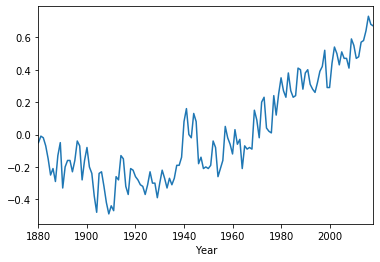

In [3]:
annual.plot()

As the annual temperature is a continuous, an exponential probability density is a good choice

$$Z(z|\lambda) = \lambda e^{- \lambda z}$$

The expected value of the exponential random variable is equal to the inverse of the parameter $\lambda$ 

$$ \mathbf{E}[Z|\lambda] = \frac{1}{\lambda}$$

Let's create variables for the parameter before and after the switch:

In [4]:
# before_mu = pm.Uniform('before_mu', -2, 2)
# before_sigma = pm.Exponential('before_sigma', 1 / annual.std())

# after_mu = pm.Uniform('after_mu', -2, 2)
# after_sigma = pm.Exponential('after_sigma', 1 / annual.std())

# x
size = 2
mu = pm.Uniform('mu', -2, 2, size=size)
sigma = pm.Exponential('sigma', 1 / annual.std(), size=size)

We also need a parameter to control the switch:

In [5]:
tau = pm.DiscreteUniform('tau', lower=0, upper=annual.shape[0])

All of these `pymc` variables are stochastic - they can be sampled from:

In [6]:
mu.random()

array([ 0.9632591 , -0.56202541])

In [7]:
sigma.random()

array([0.02245813, 0.2583534 ])

In [8]:
tau.random()

array(135)

We now need to combine these into a single parameter.  

We use the `pm.deterministic` decorator to tell `pymc` that this is a deterministic function
- all variables need to be kwargs

In [9]:
@pm.deterministic
def mu_p(tau=tau, mu=mu, count=annual.shape[0]):
    out = np.zeros(count)
    out[:tau] = mu[0]
    out[tau:] = mu[1]
    return out

@pm.deterministic
def sigma_p(tau=tau, sigma=sigma, count=annual.shape[0]):
    out = np.zeros(count)
    out[:tau] = sigma[0]
    out[tau:] = sigma[1]
    return out

Now we can finally create our object combines our data with our priors:

In [10]:
observation = pm.Normal('temperature', mu=mu_p, tau=1/sigma_p, value=annual, observed=True)

And make a `Model` instance:

In [11]:
model = pm.Model([observation, mu_p, sigma_p, tau])
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 7.2 sec

In [12]:
mcmc.trace('mu_p')[:, :]

array([[-0.18877774, -0.18877774, -0.18877774, ...,  0.37593162,
         0.37593162,  0.37593162],
       [-0.19431185, -0.19431185, -0.19431185, ...,  0.34195811,
         0.34195811,  0.34195811],
       [-0.19431185, -0.19431185, -0.19431185, ...,  0.34195811,
         0.34195811,  0.34195811],
       ...,
       [-0.17681311, -0.17681311, -0.17681311, ...,  0.38953892,
         0.38953892,  0.38953892],
       [-0.17681311, -0.17681311, -0.17681311, ...,  0.38953892,
         0.38953892,  0.38953892],
       [-0.17681311, -0.17681311, -0.17681311, ...,  0.38953892,
         0.38953892,  0.38953892]])

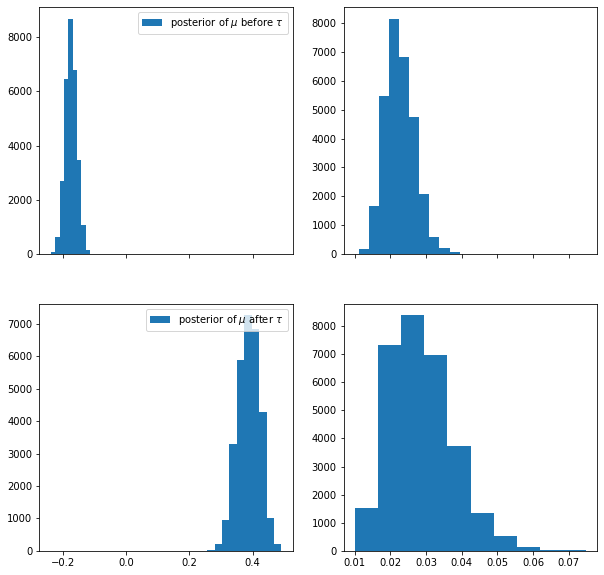

In [13]:
before_mu_samples = mcmc.trace('mu')[:, 0]
after_mu_samples = mcmc.trace('mu')[:, 1]
before_sigma_samples = mcmc.trace('sigma')[:, 0]
after_sigma_samples = mcmc.trace('sigma')[:, 1]

tau_samples = mcmc.trace('tau')[:]

f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex='col')

_ = axes[0][0].hist(before_mu_samples, label=r"posterior of $\mu$ before $\tau$")
_ = axes[1][0].hist(after_mu_samples, label=r"posterior of $\mu$ after $\tau$")

_ = axes[0][1].hist(before_sigma_samples)
_ = axes[1][1].hist(after_sigma_samples)

axes[0][0].legend(loc="upper right")
axes[1][0].legend(loc="upper right")

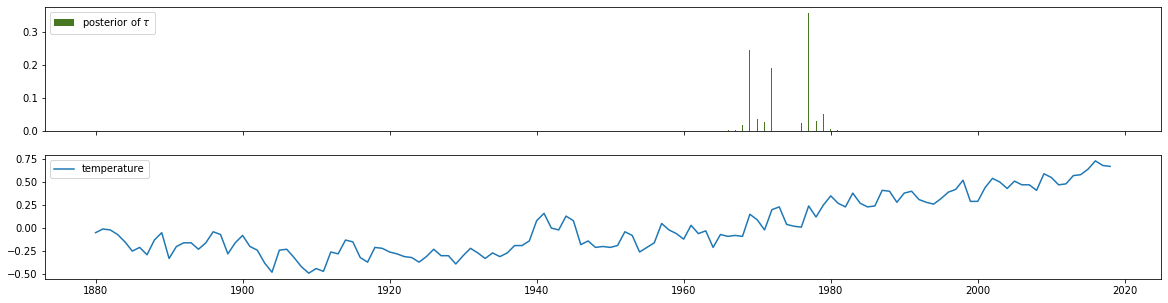

In [14]:
f, ax = plt.subplots(figsize=(20, 5), nrows=2, sharex=True)
years = tau_samples + annual.index[0]
w = 1.0 / years.shape[0] * np.ones_like(years)
ax[0].hist(years, bins=annual.shape[0], alpha=1, label=r"posterior of $\tau$", color="#467821", weights=w, rwidth=2.)
ax[0].legend(loc="upper left")
ax[0].xaxis.set_major_locator(plt.MaxNLocator(10))
_ = ax[1].plot(annual, label='temperature')
ax[1].legend(loc="upper left")

The width of these distributions shows how certain we should be

Our analysis shows support for
- a change in warming (mu0 != mu1)
- a switchpoint occured in the late 1960's / 1970's

## Statistical significance

We can visually inspect the parameters above and see a clear trend (i.e. no overlap for the mean).  

We can use our samples to determine this:

In [15]:
np.mean(before_sigma_samples < after_sigma_samples)

0.6697666666666666

We can use a similar logic for a given size of effect:

In [16]:
effect_size = 0.01

np.mean(np.abs(before_sigma_samples - after_sigma_samples) >= effect_size)

0.4062

## Practical

Extend the example above to model multiple switchpoints

## A bit more on PyMC

### Parent & child relationships

In [17]:
observation, mu, sigma

(<pymc.distributions.new_dist_class.<locals>.new_class 'temperature' at 0x12dda6b70>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'mu' at 0x12dceecc0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'sigma' at 0x12dceec50>)

In [18]:
observation.parents

{'mu': <pymc.PyMCObjects.Deterministic 'mu_p' at 0x12dce5470>,
 'tau': <pymc.PyMCObjects.Deterministic '(sigma_p_rtruediv_1)' at 0x12dda6320>}

In [19]:
mu.children

{<pymc.PyMCObjects.Deterministic 'mu_p' at 0x12dce5470>}

### Variables have values

In [20]:
observation.value

array([-0.05, -0.01, -0.02, -0.07, -0.15, -0.25, -0.21, -0.29, -0.13,
       -0.05, -0.33, -0.2 , -0.16, -0.16, -0.23, -0.16, -0.04, -0.07,
       -0.28, -0.16, -0.08, -0.2 , -0.24, -0.38, -0.48, -0.24, -0.23,
       -0.32, -0.42, -0.49, -0.44, -0.47, -0.26, -0.28, -0.13, -0.15,
       -0.32, -0.37, -0.21, -0.22, -0.26, -0.28, -0.31, -0.32, -0.37,
       -0.31, -0.23, -0.3 , -0.3 , -0.39, -0.3 , -0.22, -0.27, -0.33,
       -0.27, -0.31, -0.27, -0.19, -0.19, -0.14,  0.08,  0.16,  0.  ,
       -0.02,  0.13,  0.08, -0.18, -0.14, -0.21, -0.2 , -0.21, -0.19,
       -0.04, -0.08, -0.26, -0.21, -0.16,  0.05, -0.02, -0.06, -0.12,
        0.03, -0.06, -0.03, -0.21, -0.07, -0.09, -0.08, -0.09,  0.15,
        0.09, -0.02,  0.2 ,  0.23,  0.04,  0.02,  0.01,  0.24,  0.12,
        0.25,  0.35,  0.27,  0.23,  0.38,  0.27,  0.23,  0.24,  0.41,
        0.4 ,  0.28,  0.38,  0.4 ,  0.31,  0.28,  0.26,  0.32,  0.39,
        0.42,  0.52,  0.29,  0.29,  0.44,  0.54,  0.5 ,  0.43,  0.51,
        0.47,  0.47,

## Variables are stochastic or deterministic

Deterministic
- not random if parents values known
- made using the `@pm.deterministic` decorator
- elementary operations such as addition, exponentials etc

Stochastic
- even if you know all parent's values, it is is still random
- Poisson, DiscreteUniform, Exponential

We can call `.random()` on stochastic variables

In [21]:
mu.random()

array([-1.1683512 , -1.15529729])

## How do we include data?

Stochastic variables have kwarg `observed`

In [22]:
pm.Poisson('fixed', 1, value=data, observed=True)

<pymc.distributions.new_dist_class.<locals>.new_class 'fixed' at 0x132b1fd30>

## Using `pymc` to generate data

A superpower of machine learning

2.2.1 hacker

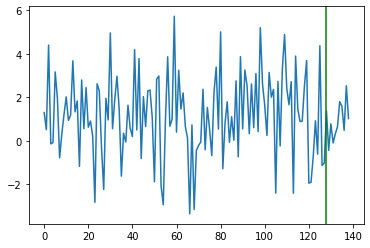

In [23]:
#  sample a switchpoint
tau = pm.rdiscrete_uniform(0, annual.shape[0])

#  sample statitics for the Gaussian
mu = pm.runiform(-2, 2, size=size)
sigma = pm.rexponential(1 / annual.std(), size=size)

mus = np.r_[
    mu[0] * np.ones(tau), mu[1] * np.ones(annual.shape[0] - tau)
]

sigmas = np.r_[
    sigma[0] * np.ones(tau), sigma[1] * np.ones(annual.shape[0] - tau)
]

data = pm.rnormal(mus, sigmas)

plt.plot(data)
_ = plt.axvline(tau, color='green')

## Revisiting the temperature dataset

If we have a look again at our dataset

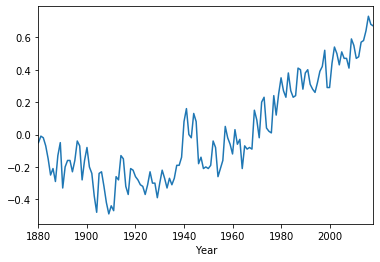

In [24]:
_ = annual.plot()

https://link.springer.com/content/pdf/10.3758%2Fs13423-017-1281-0.pdf

Let's sample

In [26]:
size = 2

mu = pm.Uniform('mu', size=size)
beta = pm.Normal('beta', mu=mu, tau=0.5)

@pm.deterministic
def mu_p(mu=beta, count=annual.shape[0]):
    out = np.full(count, mu[0])
    out *= mu[1] * np.arange(count)
    return out

observation = pm.Normal('temperature', mu=mu_p, value=annual, observed=True)

model = pm.Model([observation, mu_p])
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 0.4 sec

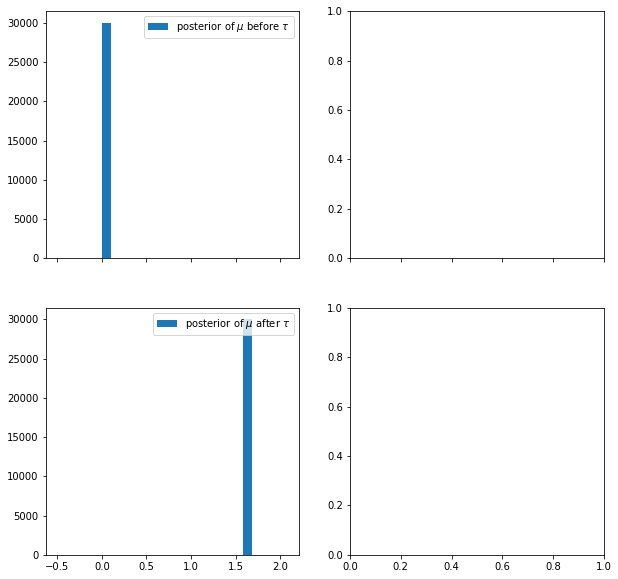

In [28]:
before_mu_samples = mcmc.trace('mu_p')[:, 0]
after_mu_samples = mcmc.trace('mu_p')[:, 1]

f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex='col')

_ = axes[0][0].hist(before_mu_samples, label=r"posterior of $\mu$ before $\tau$")
_ = axes[1][0].hist(after_mu_samples, label=r"posterior of $\mu$ after $\tau$")

#_ = axes[0][1].hist(before_sigma_samples)
#_ = axes[1][1].hist(after_sigma_samples)

axes[0][0].legend(loc="upper right")
axes[1][0].legend(loc="upper right")

Let's try to model this as a time series problem, using an autoregression model with two lags

https://towardsdatascience.com/a-bayesian-approach-to-time-series-forecasting-d97dd4168cb7